<a href="https://colab.research.google.com/github/jakeoung/teach/blob/main/ai/deepwalk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Naive attempt to implement DeepWalk for an instructive purpose. This code is not efficient. DeepWalk is a method to learn node embeddings from a graph. The idea is to use Skipgram with negative sampling to learn embeddings of nodes in a graph.

Reference
- https://arxiv.org/abs/1403.6652
- https://colab.research.google.com/github/chaklam-silpasuwanchai/Python-fo-Natural-Language-Processing/blob/main/Code/01%20-%20Fundamental/02%20-%20Word2Ve%20%28Negative%20Sampling%29%20from%20Scratch.ipynb#scrollTo=P598vUcveI3Q


## 1. Load graph (EDA)

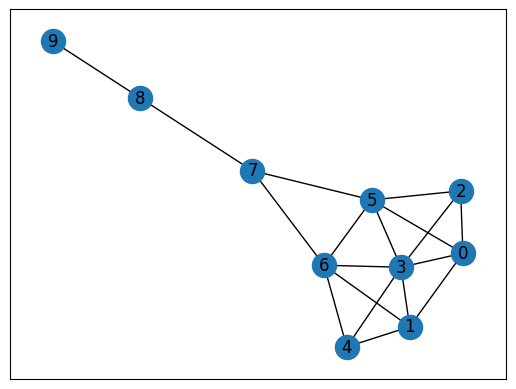

[[0.         0.25       0.25       0.25       0.         0.25
  0.         0.         0.         0.        ]
 [0.25       0.         0.         0.25       0.25       0.
  0.25       0.         0.         0.        ]
 [0.33333333 0.         0.         0.33333333 0.         0.33333333
  0.         0.         0.         0.        ]
 [0.16666667 0.16666667 0.16666667 0.         0.16666667 0.16666667
  0.16666667 0.         0.         0.        ]
 [0.         0.33333333 0.         0.33333333 0.         0.
  0.33333333 0.         0.         0.        ]
 [0.2        0.         0.2        0.2        0.         0.
  0.2        0.2        0.         0.        ]
 [0.         0.2        0.         0.2        0.2        0.2
  0.         0.2        0.         0.        ]
 [0.         0.         0.         0.         0.         0.33333333
  0.33333333 0.         0.33333333 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.5        0.         0.5       ]
 [0.      

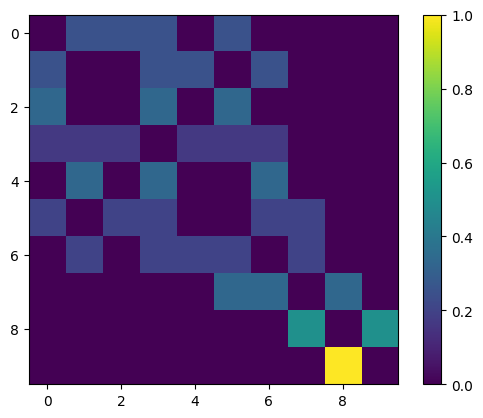

In [8]:
# !pip install lightning
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import networkx as nx

# Load the protein graph
G = nx.krackhardt_kite_graph()
num_nodes = len(G.nodes())

nx.draw_networkx(G, with_labels=True)
plt.show()

# Compute the transition matrix
A = nx.adjacency_matrix(G).todense()
D = np.sum(A, axis=0)
Dinv = np.diag(1.0 / D) # we just normalize, dividing by the sum for each row
R = Dinv.dot(A) # transition matrix

print(R)

# Visualize the transition probability?
plt.imshow(R)
plt.colorbar()

## 2. Random walk from a graph G
It corresponds to sampling a sequence of words in word2vec

In [47]:

def random_walk(R, walk_length=3):
    """
    Generate a random walk by R.

    Args:
        R: Transition matrix.
        walk_length: Length of the random walk.

    Returns:
        A list of nodes in the random walk.
    """

    # Initialize the random walk with a random node.
    current_node = random.choice(range(len(R)))
    walk = [current_node]

    # Generate the random walk by repeatedly selecting the next node based on the transition probabilities.
    for _ in range(walk_length - 1):
        next_node = np.random.choice(range(len(R)), p=R[current_node])
        walk.append(next_node)
        current_node = next_node

    return walk

# test random_walk function
walk = random_walk(R)
walk

[4, 1, 4]

## 3. Prepare train data

In [48]:
def random_batch(batch_size, walk_length, num_neg_samples=3):
    inputs = np.zeros((batch_size, 1), dtype=np.int32)
    labels = np.zeros((batch_size, 1), dtype=np.int32)
    neg_samples = np.zeros((batch_size, num_neg_samples), dtype=np.int32)

    for i in range(batch_size):
        walk = random_walk(R, walk_length)
        inputs[i,:] = walk[0] # just save node index
        idx_rand = np.random.randint(walk_length-1)+1
        labels[i,:] = walk[idx_rand] # not efficient so far
        # labels[i,:] = walk[1:]

        # find negative samples
        idx_not_used = np.where(~np.isin(range(num_nodes), walk))[0]
        neg_samples[i,:] = np.random.choice(idx_not_used, num_neg_samples, replace=False)
        # idx_random = np.random.randint(len(idx_not_used))
        # neg_samples[i,:] = idx_not_used[idx_random][:walk_length-1]

    return inputs, labels, neg_samples

# test random_batch function
batch_size = 2
inputs, labels, neg_samples = random_batch(batch_size, 3)

print('inputs:', inputs)
print('labels:', labels)
print('neg_samples:', neg_samples)

inputs: [[3]
 [1]]
labels: [[3]
 [4]]
neg_samples: [[2 4 9]
 [9 6 5]]


## 4. Model

In [49]:
# Define the DeepWalk model
class DeepWalk(nn.Module):
    def __init__(self, num_nodes, embedding_dim):
        super(DeepWalk, self).__init__()
        self.num_nodes = num_nodes
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(num_nodes, embedding_dim)
        self.logsigmoid = nn.LogSigmoid()

    # return center vector, context vectors
    def forward(self, inp, target, neg_samples):
        start_emb = self.embedding(inp)
        target_emb = self.embedding(target)
        neg_embed = -self.embedding(neg_samples)

        pos_score = target_emb.bmm(start_emb.transpose(1,2)).squeeze(2) # [b, 1]
        neg_score = neg_embed.bmm(start_emb.transpose(1,2)) # [b, k, 1]

        loss = self.logsigmoid(pos_score) + torch.sum(self.logsigmoid(neg_score), 1)

        return -torch.mean(loss)

## 5. Train

Epoch 1, Loss: 2.65449857711792
Epoch 101, Loss: 2.1985831260681152
Epoch 201, Loss: 2.60636568069458
Epoch 301, Loss: 2.632054090499878
Epoch 401, Loss: 2.4284474849700928
Epoch 501, Loss: 2.785715103149414
Epoch 601, Loss: 2.8885209560394287
Epoch 701, Loss: 2.2237894535064697
Epoch 801, Loss: 2.8131086826324463
Epoch 901, Loss: 2.1227266788482666
Epoch 1001, Loss: 2.47929310798645
Epoch 1101, Loss: 1.8053615093231201
Epoch 1201, Loss: 2.5623559951782227
Epoch 1301, Loss: 2.296133041381836
Epoch 1401, Loss: 2.3728489875793457
Epoch 1501, Loss: 2.339043140411377
Epoch 1601, Loss: 2.2710928916931152
Epoch 1701, Loss: 1.6778959035873413
Epoch 1801, Loss: 2.048039197921753
Epoch 1901, Loss: 2.5964388847351074
Epoch 2001, Loss: 2.0987043380737305
Epoch 2101, Loss: 2.2220499515533447
Epoch 2201, Loss: 1.7999608516693115
Epoch 2301, Loss: 1.8844980001449585
Epoch 2401, Loss: 2.2304656505584717
Epoch 2501, Loss: 1.9082905054092407
Epoch 2601, Loss: 2.577512741088867
Epoch 2701, Loss: 2.29268

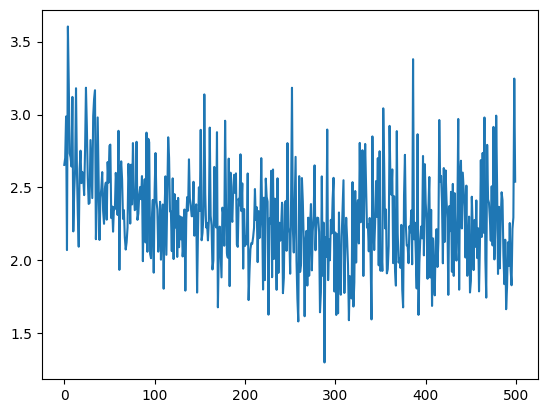

In [50]:
batch_size = 10
embedding_size = 2
num_neg_samples = 3
walk_length = 2

model = DeepWalk(num_nodes, embedding_dim=embedding_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

# Train the model
epochs = 5000
loss_save = []

for epoch in range(epochs):
    inp_batch, target_batch, neg_samples_batch = random_batch(batch_size, walk_length, num_neg_samples)
    inp_batch = torch.LongTensor(inp_batch) # [b, 1, emb_size]
    target_batch = torch.LongTensor(target_batch)
    neg_samples_batch = torch.LongTensor(neg_samples_batch) # [b, num_neg_samples, emb_size]

    optimizer.zero_grad()
    loss = model(inp_batch, target_batch, neg_samples_batch)

    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        loss_save.append(loss.item())

    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

plt.plot(loss_save)

# 6. Visualization

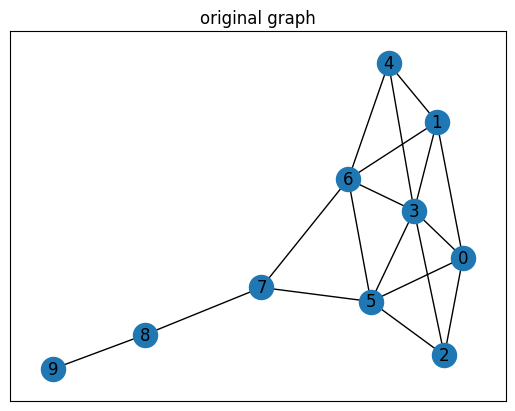

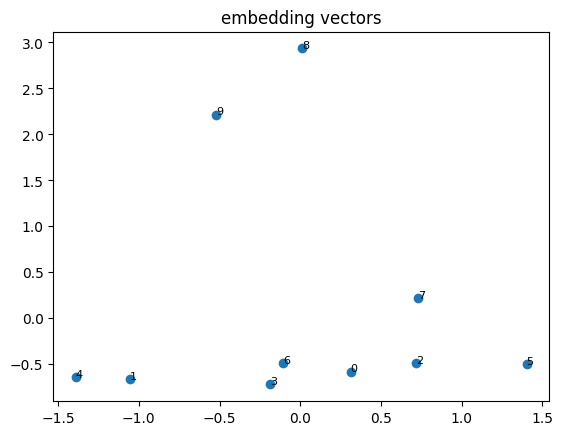

In [61]:
nx.draw_networkx(G, with_labels=True)
plt.title("original graph")
plt.show()

vecs = model.embedding(torch.LongTensor(range(num_nodes))) # [num_nodes x emb_dim]
vecs_np = vecs.detach().numpy()

if embedding_size > 2:
    # Visualize the embeddings using TSNE
    tsne = TSNE(n_components=2)
    vecs_embedded = tsne.fit_transform(vecs_np)

    # Plot the embedded nodes
    plt.figure(figsize=(6, 6))
    plt.scatter(vecs_embedded[:, 0], vecs_embedded[:, 1])

    # Label the nodes with their numbers
    for i, (x, y) in enumerate(vecs_embedded):
        plt.text(x, y, str(i), fontsize=8)


else:
    plt.scatter(vecs_np[:, 0], vecs_np[:, 1])

    # Label the nodes with their numbers
    for i, (x, y) in enumerate(vecs_np):
        plt.text(x, y, str(i), fontsize=8)


plt.title("embedding vectors")
plt.show()